In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime



In [45]:
cd /Users/williamzhou/Desktop/russian_real_estate

/Users/williamzhou/Desktop/russian_real_estate


In [46]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
macro = pd.read_csv('./macro.csv')
id_test = test.id

In [47]:
# y_train = np.log1p(train["price_doc"]) # log1p transformation may hurt performance
y_train = train["price_doc"]
x_train = train.drop(["id", "price_doc"], axis=1)
x_test = test.drop(["id"], axis=1)


In [48]:
num_train = len(train)
df_all = pd.concat([x_train,x_test])

In [168]:
# change ID variable to categorical variables
df_all[['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_terminal']]=df_all[['ID_big_road1','ID_big_road2',
                                        'ID_bus_terminal','ID_metro',
                                       'ID_railroad_station_avto',
                                       'ID_railroad_terminal']].astype(object)

In [51]:
# Create new features based on timestamp
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)




# df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
# df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
# df_all['life_full_sq_ratio'] = df_all['life_sq']/df_all['full_sq']
# df_all['avg_room_sq'] = (df_all['life_sq']-df_all['kitch_sq'])/df_all['num_room']


In [52]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

In [53]:
df_all=df_all.drop(['timestamp'],axis =1 )

In [11]:
x_train = df_all.iloc[:num_train,:]
x_test = df_all.iloc[num_train:,:]

print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)

('x_train shape', (30471, 291))
('x_test shape', (7662, 291))
('y_train shape', (30471,))


In [12]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:8.21935e+06	test-rmse:8.22369e+06
[50]	train-rmse:2.51571e+06	test-rmse:2.88855e+06
[100]	train-rmse:2.18532e+06	test-rmse:2.70148e+06
[150]	train-rmse:2.06252e+06	test-rmse:2.66232e+06
[200]	train-rmse:1.97118e+06	test-rmse:2.64464e+06
[250]	train-rmse:1.89687e+06	test-rmse:2.63075e+06
[300]	train-rmse:1.83279e+06	test-rmse:2.61984e+06
[350]	train-rmse:1.77573e+06	test-rmse:2.61752e+06
[400]	train-rmse:1.72415e+06	test-rmse:2.61375e+06
[450]	train-rmse:1.67849e+06	test-rmse:2.61155e+06
[500]	train-rmse:1.63683e+06	test-rmse:2.61129e+06
CPU times: user 6min 57s, sys: 2.49 s, total: 7min
Wall time: 7min 3s


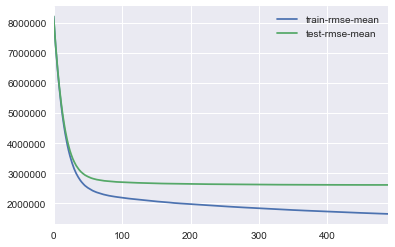

In [13]:
%%time
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [14]:
%%time
num_boost_rounds = len(cv_output)
print(num_boost_rounds)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

490
CPU times: user 3min 48s, sys: 998 ms, total: 3min 49s
Wall time: 3min 50s


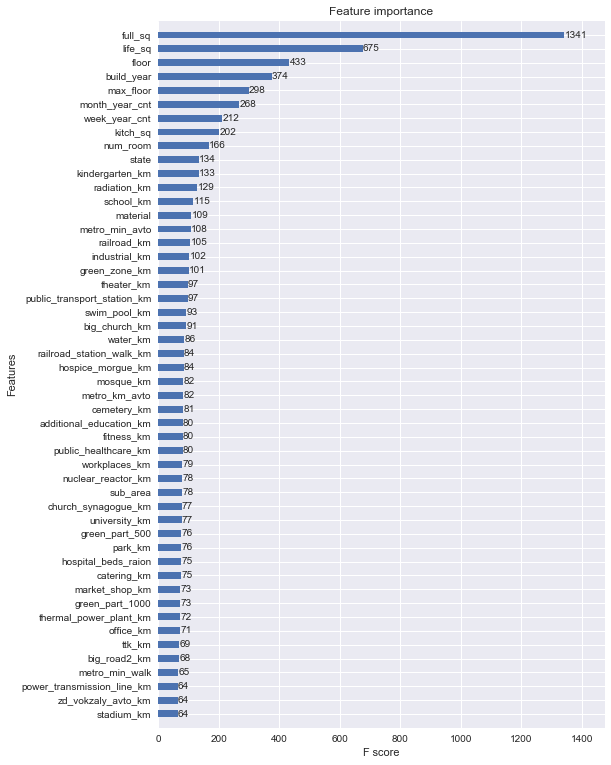

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [60]:
importance = model.get_fscore()
importance = pd.DataFrame(sorted(importance.items()),columns =['feature','fscore'])
importance = importance.sort_values(by='fscore',ascending=False).reset_index(drop=True)
importance_features = list(importance.loc[:,'feature'])
importance_features


['full_sq',
 'life_sq',
 'floor',
 'build_year',
 'max_floor',
 'month_year_cnt',
 'week_year_cnt',
 'kitch_sq',
 'num_room',
 'state',
 'kindergarten_km',
 'radiation_km',
 'school_km',
 'material',
 'metro_min_avto',
 'railroad_km',
 'industrial_km',
 'green_zone_km',
 'public_transport_station_km',
 'theater_km',
 'swim_pool_km',
 'big_church_km',
 'water_km',
 'railroad_station_walk_km',
 'hospice_morgue_km',
 'metro_km_avto',
 'mosque_km',
 'cemetery_km',
 'public_healthcare_km',
 'fitness_km',
 'additional_education_km',
 'workplaces_km',
 'sub_area',
 'nuclear_reactor_km',
 'university_km',
 'church_synagogue_km',
 'park_km',
 'green_part_500',
 'catering_km',
 'hospital_beds_raion',
 'market_shop_km',
 'green_part_1000',
 'thermal_power_plant_km',
 'office_km',
 'ttk_km',
 'big_road2_km',
 'metro_min_walk',
 'power_transmission_line_km',
 'stadium_km',
 'zd_vokzaly_avto_km',
 'exhibition_km',
 'bus_terminal_avto_km',
 'museum_km',
 'ts_km',
 'area_m',
 'sadovoe_km',
 'ice_rink_

In [64]:
y_predict = model.predict(dtest)
# y_predict = np.exp(y_predict) - 1
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
df_sub.to_csv('./sub.csv', index=False)


In [65]:
importance.to_csv('./feature_importance.csv')

## Select top N features

In [156]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
rmse_result_dict={}

In [160]:
for i in [95]:
    # create subset of df_all
    df_all_subset = df_all.loc[:,importance_features[:i]]
#     prepare data
    x_train_subset = df_all_subset.iloc[:num_train,:]
    dtrain_subset = xgb.DMatrix(x_train_subset, y_train)
#     Train model / Cross validation 
    cv_output = xgb.cv(xgb_params, dtrain_subset, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
    print('finish',i)
#     save result
    rmse_result_dict[i]=cv_output.iloc[-1,:]
    

[0]	train-rmse:8.2065e+06	test-rmse:8.21161e+06
[50]	train-rmse:2.53974e+06	test-rmse:2.89098e+06
[100]	train-rmse:2.20286e+06	test-rmse:2.70089e+06
[150]	train-rmse:2.07411e+06	test-rmse:2.65747e+06
[200]	train-rmse:1.98022e+06	test-rmse:2.63322e+06
[250]	train-rmse:1.90464e+06	test-rmse:2.62288e+06
[300]	train-rmse:1.84187e+06	test-rmse:2.61501e+06
[350]	train-rmse:1.78237e+06	test-rmse:2.60802e+06
[400]	train-rmse:1.73008e+06	test-rmse:2.605e+06
[450]	train-rmse:1.68586e+06	test-rmse:2.60207e+06
[500]	train-rmse:1.64236e+06	test-rmse:2.59955e+06
('finish', 95)


In [158]:
test_rmse_mean=[]
top_n_features=[]
for i in range(80,111,5):
    top_n_features.append(i)
    test_rmse_mean.append(rmse_result_dict[i]['test-rmse-mean'])

    

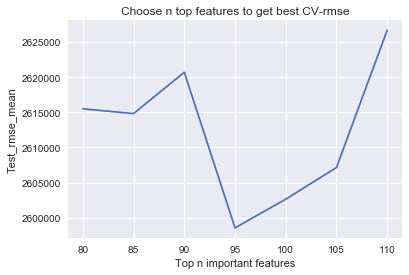

In [159]:
# rmse=pd.DataFrame(zip(top_n_features,(x/10**3 for x in test_rmse_mean)),columns=['Top_n_features','test_rmse_mean'])
rmse=pd.DataFrame(zip(top_n_features,test_rmse_mean),columns=['Top_n_features','test_rmse_mean'])
fig, ax = plt.subplots()
plt.plot(rmse.Top_n_features,rmse.test_rmse_mean)
ax.set(xlabel='Top n important features',
       ylabel='Test_rmse_mean',
       title = 'Choose n top features to get best CV-rmse')

plt.show()

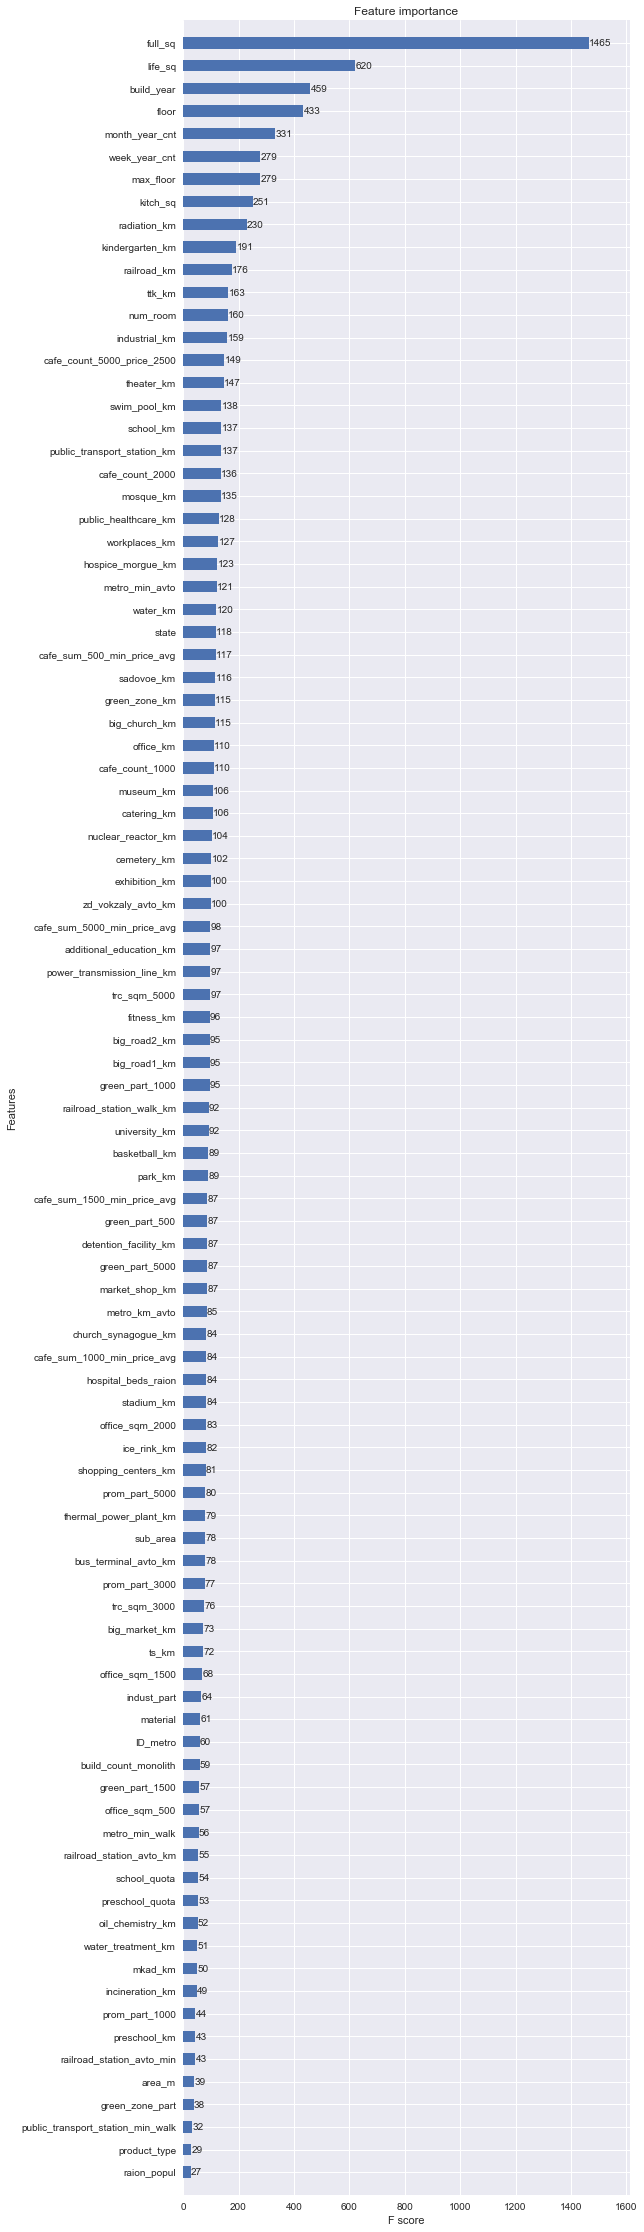

In [165]:
num_boost_round = model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_subset, num_boost_round=num_boost_round)
fig, ax = plt.subplots(1, 1, figsize=(8, 40))
xgb.plot_importance(model, max_num_features=200, height=0.5, ax=ax)
plt.show()


In [167]:
x_test_subset = df_all_subset.iloc[num_train:,:]
dtest_subset = xgb.DMatrix(x_test_subset)

y_pred = model.predict(dtest_subset)
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
df_sub.to_csv('./sub.csv', index=False)